
# Crop Recommender System — End‑to‑End EDA & Data Readiness Notebook

**Dataset**: Kaggle “Crop Recommendation Dataset” (N, P, K, temperature, humidity, pH, rainfall, label)  
**Goal**: Build a clean, reusable pipeline that covers:
- Loading & Sampling, removing unnecessary column (Read source files)
- Data Preprocessing (type correction, time binning, missing values, outliers, encoding)
- EDA (correlation analysis, visualizations, feature importance)
- Feature Engineering (domain‑aware bins/placeholders)
- Data Readiness for Modeling (train/val/test split)

> ⚙️ **How to use**: Set `DATA_PATH` to your local CSV and run the notebook top‑down.


In [1]:

# --- Imports
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Tuple

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# --- Config
# Set this to your local path for the Kaggle CSV (e.g., 'crop_recommendation.csv')
#DATA_PATH = r"D:\Study\BITS\code\src\archive (6)\Crop Recommendation dataset\Train Dataset.csv"  # <-- change me after download
DATA_PATH = "./Downloads/Train Dataset.csv" 
RANDOM_STATE = 42
pd.set_option('display.max_columns', None)


## Loading and Sampling — Read source files

In [2]:
# Helper: safe load with friendly error
def load_csv(path: str) -> pd.DataFrame:
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"CSV not found at {p.resolve()}. Please update DATA_PATH.")
    df_ = pd.read_csv(p)
    return df_

# Load
df_raw = load_csv(DATA_PATH)

# --- Canonicalize headers (idempotent)
def canon(name: str) -> str:
    return (
        str(name)
        .strip()
        .lower()
        .replace('\n',' ')
        .replace('\r',' ')
        .replace('\t',' ')
        .replace('  ', ' ')
        .replace(' ', '_')
    )

df_raw = df_raw.rename(columns={c: canon(c) for c in df_raw.columns})
print("Canonicalized columns:", list(df_raw.columns))

# --- Try to detect target column if not already set
possible_targets = ['label','crop','target','class','crop_label','cropname','crop_name']
target_col = next((c for c in possible_targets if c in df_raw.columns), None)
if target_col is None:
    obj_cands = [c for c in df_raw.columns if df_raw[c].dtype == 'object']
    if obj_cands:
        ranked = sorted(obj_cands, key=lambda c: df_raw[c].nunique())
        for c in ranked:
            if df_raw[c].nunique() <= 100:
                target_col = c
                break
if target_col is None:
    raise RuntimeError("Could not detect the target column. Set `target_col` manually.")

print("Detected target column:", target_col)


#dropping column: 0 Unnamed , which is sequence number and doesn't have significance in crop recommendation
df_raw = df_raw.drop(columns=["unnamed:_0"])

print("After dropping column, canonicalized columns:", list(df_raw.columns))

# Optional: rename the target to 'label' for consistency (rest of notebook uses target_col variable anyway)
# df_raw = df_raw.rename(columns={target_col: 'label'})
# target_col = 'label'

# Stratified sample for quick experiments (set FRACTION < 1.0 to sample)
FRACTION = 1.0  # e.g., 0.3 for a 30% sample
if FRACTION < 1.0:
    df_sampled = (df_raw
                  .groupby(target_col, group_keys=False, sort=False)
                  .apply(lambda x: x.sample(frac=FRACTION, random_state=RANDOM_STATE))
                  .reset_index(drop=True))
else:
    df_sampled = df_raw.copy()

print('Sampled shape:', df_sampled.shape)
display(df_sampled[target_col].value_counts().head())


Canonicalized columns: ['unnamed:_0', 'crop', 'n', 'p', 'k', 'ph', 'rainfall', 'temperature']
Detected target column: crop
After dropping column, canonicalized columns: ['crop', 'n', 'p', 'k', 'ph', 'rainfall', 'temperature']
Sampled shape: (18079, 7)


crop
rice        2245
maize       1976
moong       1327
wheat       1287
rapeseed    1118
Name: count, dtype: int64

In [3]:
df = df_sampled.copy()


# Build numeric list from known names if present; otherwise infer numeric
common_numeric = ['n','p','k','temperature','humidity','ph','rainfall']
expected_numeric = [c for c in common_numeric if c in df.columns]

# If some numeric columns are named differently, infer numeric by dtype as a fallback
if not expected_numeric:
    expected_numeric = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != target_col]

# Coerce numerics (bad parses -> NaN, handled later by imputers)
for col in expected_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Time column detection (most Kaggle versions have no time column; this is safe if absent)
candidate_time_cols = [c for c in df.columns if 'date' in c or c in ('time','timestamp','datetime','month')]


## Data Preprocessing

### Data type correction

In [4]:
df = df_sampled.copy()


# Canonical alias map for the Kaggle crop dataset
alias_map = {
    'n': ['n', 'nitrogen'],
    'p': ['p', 'phosphorus'],
    'k': ['k', 'potassium'],
    'temperature': ['temperature', 'temp', 'temperature_c', 'avg_temp', 'average_temperature'],
    'humidity': ['humidity', 'relative_humidity', 'rel_humidity'],
    'ph': ['ph', 'soil_ph'],
    'rainfall': ['rainfall', 'rain_fall', 'annual_rainfall', 'rain', 'rainfall_mm']
}

# Build a mapping from canonical name -> actual present column in df (first match wins)
present_map = {}
cols_lower = {canon(c): c for c in df.columns}  # canon->original

for canon_key, candidates in alias_map.items():
    found = None
    for cand in candidates:
        ckey = canon(cand)
        if ckey in cols_lower:
            found = cols_lower[ckey]
            break
    if found:
        present_map[canon_key] = found

# Final list of numeric columns we expect (those actually present)
expected_numeric = list(present_map.values())

# If none matched (unusual), fall back to dtype-based inference (exclude the target)
if not expected_numeric:
    expected_numeric = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != target_col]

# Coerce numerics (bad parses -> NaN; handled later by imputers)
for col in expected_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Time column detection (no-op for typical Kaggle file)
candidate_time_cols = [c for c in df.columns if any(k in c for k in ['date','time','timestamp','datetime','month'])]
df.dtypes


crop            object
n                int64
p                int64
k                int64
ph             float64
rainfall       float64
temperature    float64
dtype: object

### Classify time data into categories or bins (if time columns exist)

In [5]:

def month_to_season(m):
    # Simple Northern Hemisphere mapping (adjust for locale),
    # returns one of ['Winter','Spring','Summer','Autumn'] or None
    if pd.isna(m): return None
    m = int(m)
    if m in (12,1,2):  return 'Winter'
    if m in (3,4,5):   return 'Spring'
    if m in (6,7,8):   return 'Summer'
    if m in (9,10,11): return 'Autumn'
    return None

added_cols = []
for c in candidate_time_cols:
    if np.issubdtype(df[c].dtype, np.datetime64):
        df[c + '_month']  = df[c].dt.month
        df[c + '_season'] = df[c + '_month'].apply(month_to_season)
        added_cols.extend([c + '_month', c + '_season'])
    elif df[c].dtype == 'int64' or df[c].dtype == 'float64':
        # If it's numeric month already
        df[c + '_season'] = df[c].apply(month_to_season)
        added_cols.append(c + '_season')

print('Time-derived columns:', added_cols)
df.head(3)


Time-derived columns: []


,crop,n,p,k,ph,rainfall,temperature
0,barley,70,40,45,5.54,75.32,22.676000
1,sunflower,50,60,30,5.54,297.66,29.566667
2,sweetpotato,90,20,120,5.02,689.88,29.037273


### Handling missing values — audit & plan

In [6]:

def missing_report(frame: pd.DataFrame) -> pd.DataFrame:
    miss = frame.isna().sum().sort_values(ascending=False)
    pct  = (miss / len(frame)).round(4)
    out  = pd.DataFrame({'missing': miss, 'pct': pct})
    return out[out['missing'] > 0]

missing_report(df)


,missing,pct


### Outlier detection (Z-score & IQR) — non-destructive summary

In [7]:
def outlier_summary_numeric(frame: pd.DataFrame, cols: list) -> pd.DataFrame:
    rows = []
    for c in cols:
        if c not in frame.columns:
            # Skip silently if alias wasn't found
            continue
        s = pd.to_numeric(frame[c], errors='coerce').dropna().astype(float)
        if s.empty:
            continue
        q1, q3 = np.percentile(s, [25, 75])
        iqr = q3 - q1
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        iqr_count = int(((s < low) | (s > high)).sum())

        std = s.std(ddof=0)
        std = std if std and not np.isnan(std) else 1.0
        z_count = int((np.abs((s - s.mean()) / std) > 3.0).sum())

        rows.append({'col': c, 'iqr_outliers': iqr_count, 'z>3_outliers': z_count})
    return pd.DataFrame(rows).sort_values('iqr_outliers', ascending=False)

outlier_summary_numeric(df, expected_numeric)


,col,iqr_outliers,z>3_outliers
4,ph,2361,40
2,k,1203,73
0,n,1109,0
3,temperature,346,316
5,rainfall,256,256
1,p,32,32


### Encoding — label encode target, one-hot any categorical features (if present)

In [8]:
#expected target
expected_target = "crop"
# Identify columns
target_col = expected_target if expected_target in df.columns else None
feature_cols = [c for c in df.columns if c != target_col]

# Categorical feature candidates (excluding target)
cat_cols = [c for c in feature_cols if df[c].dtype == 'object' or str(df[c].dtype).startswith('category')]
num_cols = [c for c in feature_cols if c not in cat_cols]

print('Target:', target_col)
print('Numeric features:', num_cols)
print('Categorical features:', cat_cols[:10], '(showing up to 10)')

# Label encode target
le = None
if target_col:
    le = LabelEncoder()
    df[target_col] = le.fit_transform(df[target_col])
    classes_ = list(le.classes_)
    print('Target classes:', classes_)


Target: crop
Numeric features: ['n', 'p', 'k', 'ph', 'rainfall', 'temperature']
Categorical features: [] (showing up to 10)
Target classes: ['banana', 'barley', 'bittergourd', 'blackgram', 'blackpepper', 'bottlegourd', 'brinjal', 'cabbage', 'cardamom', 'cauliflower', 'coriander', 'cotton', 'cucumber', 'drumstick', 'garlic', 'grapes', 'horsegram', 'jackfruit', 'jowar', 'jute', 'ladyfinger', 'maize', 'mango', 'moong', 'onion', 'orange', 'papaya', 'pineapple', 'potato', 'pumpkin', 'radish', 'ragi', 'rapeseed', 'rice', 'soyabean', 'sunflower', 'sweetpotato', 'tomato', 'turmeric', 'wheat']


## EDA

### Correlation Analysis (numeric only)

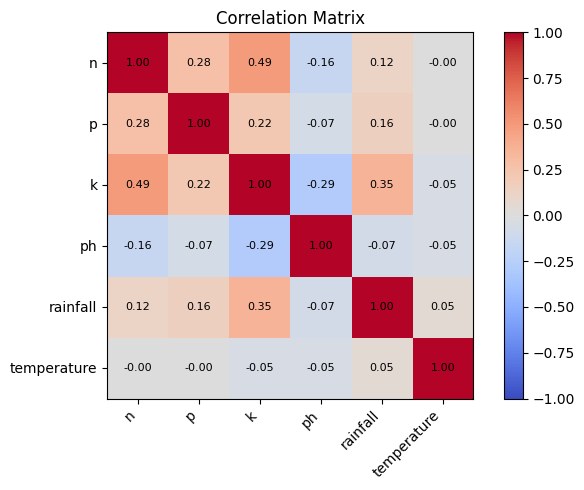

,n,p,k,ph,rainfall,temperature
n,1.000000,0.277297,0.490009,-0.155820,0.124095,-0.003405
p,0.277297,1.000000,0.216846,-0.065773,0.155127,-0.001412
k,0.490009,0.216846,1.000000,-0.285927,0.351956,-0.050925
ph,-0.155820,-0.065773,-0.285927,1.000000,-0.070842,-0.050434
rainfall,0.124095,0.155127,0.351956,-0.070842,1.000000,0.047469
temperature,-0.003405,-0.001412,-0.050925,-0.050434,0.047469,1.000000


In [9]:
num_df = df[num_cols].copy()
corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(7,5))
im = plt.imshow(corr, interpolation='nearest', cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.xticks(range(len(num_df.columns)), num_df.columns, rotation=45, ha='right')
plt.yticks(range(len(num_df.columns)), num_df.columns)
plt.colorbar(im)

# Add numbers inside the cells
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = f"{corr.iloc[i, j]:.2f}"
        plt.text(j, i, text,
                 ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

corr


### Visualizations: distributions & boxplots (numeric)

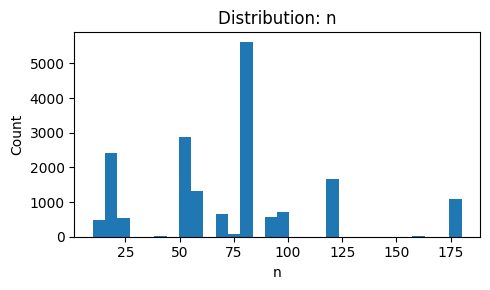

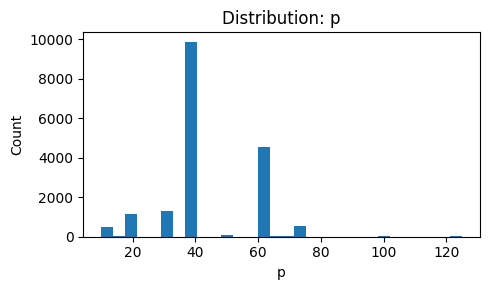

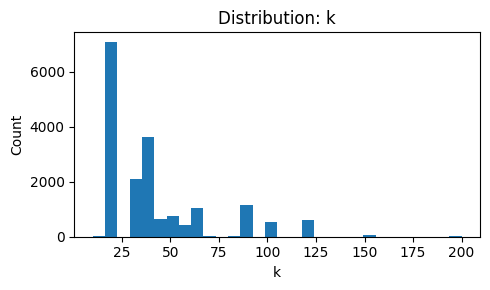

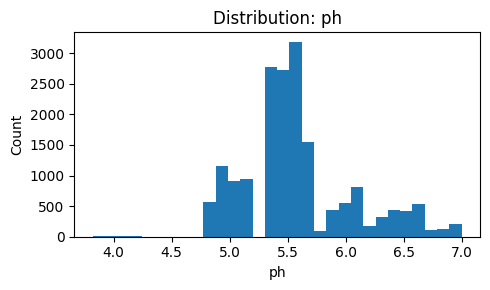

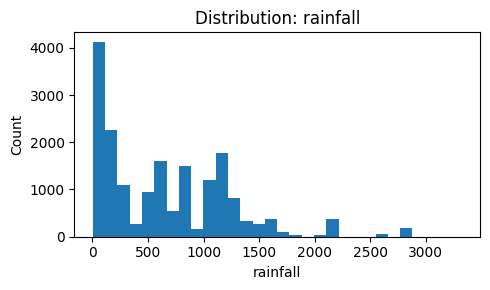

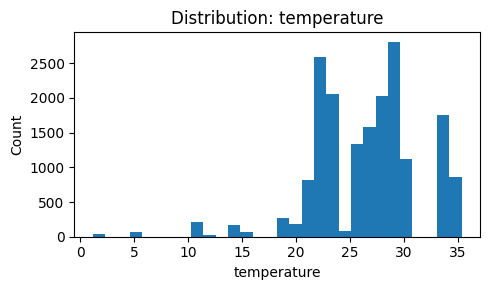

C:\Users\himas\AppData\Local\Temp\ipykernel_16608\1270514780.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[c].dropna() for c in num_cols], labels=num_cols, vert=True, showmeans=True)


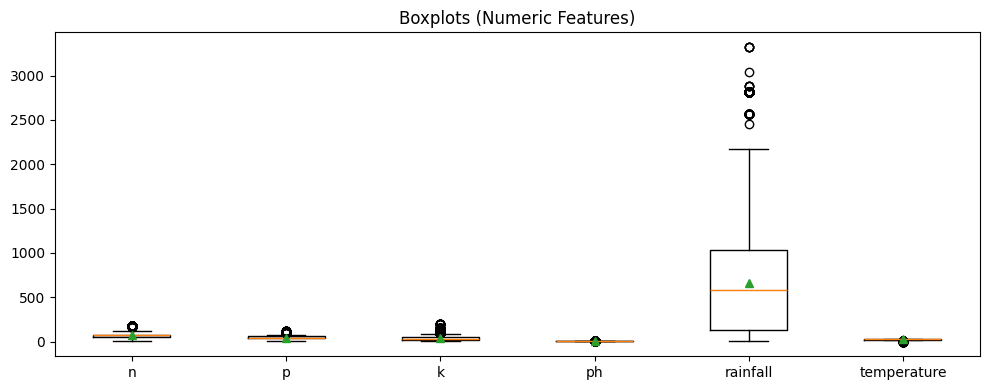

In [10]:

# Histograms
for c in num_cols:
    plt.figure(figsize=(5,3))
    plt.hist(df[c].dropna(), bins=30)
    plt.title(f'Distribution: {c}')
    plt.xlabel(c); plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Boxplots
plt.figure(figsize=(10,4))
plt.boxplot([df[c].dropna() for c in num_cols], labels=num_cols, vert=True, showmeans=True)
plt.title('Boxplots (Numeric Features)')
plt.tight_layout()
plt.show()


### Class distribution

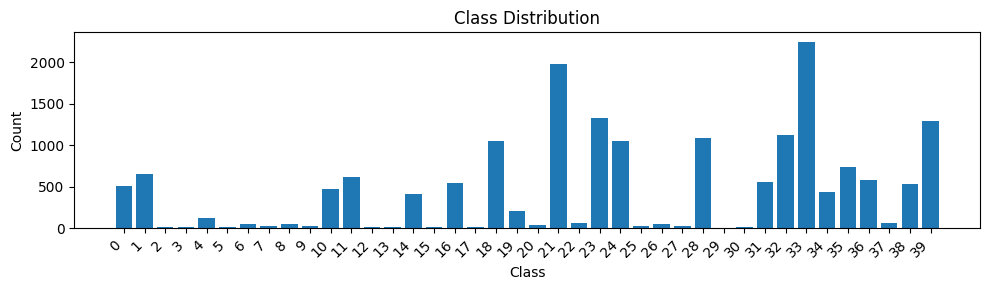

crop
0    507
1    654
2     11
3     11
4    119
Name: count, dtype: int64

In [11]:
# Ensure target_col is defined (re-detect if not)
if 'target_col' not in locals() or target_col is None:
    possible_targets = ['label','crop','target','class','crop_label','cropname','crop_name']
    target_col = next((c for c in possible_targets if c in df.columns), None)

if target_col is not None:
    vc = df[target_col].value_counts().sort_index()
    plt.figure(figsize=(10,3))
    plt.bar(range(len(vc)), vc.values, tick_label=vc.index)
    plt.title('Class Distribution')
    plt.xlabel('Class'); plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    display(vc.head())
else:
    print('Could not detect target column. Please set `target_col` manually, e.g.:')
    print("target_col = 'crop'")


## Feature Engineering


Below are simple, domain‑aware starters you can toggle on/off:
- **pH bins** (acidic/neutral/alkaline)
- **Rainfall bins** (low/medium/high)
- **Temperature bins** (cool/warm/hot)
- **Season** (if time available)

These engineered columns are optional and can be dropped later if they don’t help.


In [12]:

def add_domain_bins(frame: pd.DataFrame) -> pd.DataFrame:
    g = frame.copy()

    if 'ph' in g.columns:
        g['ph_bin'] = pd.cut(g['ph'], bins=[-np.inf, 6.0, 7.5, np.inf], labels=['acidic','neutral','alkaline'])
    if 'rainfall' in g.columns:
        # bins roughly tuned to the Kaggle dataset distribution
        q = g['rainfall'].quantile([0.33, 0.66])
        g['rainfall_bin'] = pd.cut(g['rainfall'], bins=[-np.inf, q.iloc[0], q.iloc[1], np.inf],
                                   labels=['low','medium','high'])
    if 'temperature' in g.columns:
        q = g['temperature'].quantile([0.33, 0.66])
        g['temp_bin'] = pd.cut(g['temperature'], bins=[-np.inf, q.iloc[0], q.iloc[1], np.inf],
                               labels=['cool','warm','hot'])
    return g

df_fe = add_domain_bins(df)
df_fe.head(3)


,crop,n,p,k,ph,rainfall,temperature,ph_bin,rainfall_bin,temp_bin
0,1,70,40,45,5.54,75.32,22.676000,acidic,low,cool
1,35,50,60,30,5.54,297.66,29.566667,acidic,medium,hot
2,36,90,20,120,5.02,689.88,29.037273,acidic,medium,hot


## Data Readiness for Modeling

### Train/Validation/Test split (stratified where possible)

In [13]:
from sklearn.preprocessing import LabelEncoder

if target_col is None:
    raise RuntimeError("target_col is not set. Please detect or set it before splitting.")

y_raw = df_fe[target_col]

# Ensure numeric labels (consistent across all splits)
le = LabelEncoder()
y_all = le.fit_transform(y_raw.astype(str))
class_names = list(le.classes_)  # keep for later reports/plots

X_all = df_fe.drop(columns=[target_col])

# 70/15/15 stratified split on encoded labels
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_all, y_all, test_size=0.30, random_state=RANDOM_STATE, stratify=y_all
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_tmp
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

# Safe class distribution printouts
train_counts = np.bincount(y_train, minlength=len(class_names))
val_counts   = np.bincount(y_val,   minlength=len(class_names))
test_counts  = np.bincount(y_test,  minlength=len(class_names))

print('Target distribution (train):', train_counts[:10], '...')
print('Target distribution (val):  ', val_counts[:10],  '...')
print('Target distribution (test): ', test_counts[:10], '...')

# Optional: pretty table of counts per class
import pandas as pd
dist = pd.DataFrame({
    'class': class_names,
    'train': train_counts,
    'val':   val_counts,
    'test':  test_counts
}).sort_values('class').reset_index(drop=True)
display(dist.head(20))


Train: (12655, 9) Val: (2712, 9) Test: (2712, 9)
Target distribution (train): [355 458 331 429  14  12 291  13 381  13] ...
Target distribution (val):   [76 98 71 92  3  3 62  3 82  2] ...
Target distribution (test):  [76 98 71 92  3  2 62  3 82  3] ...


,class,train,val,test
0,0,355,76,76
1,1,458,98,98
2,10,331,71,71
3,11,429,92,92
4,12,14,3,3
5,13,12,3,2
6,14,291,62,62
7,15,13,3,3
8,16,381,82,82
9,17,13,2,3


### Preprocessing pipeline (impute → encode → scale numeric (optional))

In [14]:

# Numeric pipeline
num_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # Uncomment the next line if you plan to use distance-based models
    # ('scaler', StandardScaler())
])

# Categorical pipeline
cat_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_tf, num_cols),
        ('cat', cat_tf, cat_cols)
    ],
    remainder='drop'
)

# Example baseline model (can be swapped later)
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe = Pipeline(steps=[('prep', preprocess), ('model', clf)])
pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['n', 'p', 'k', 'ph',
                                                   'rainfall', 'temperature']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  [])])),
                ('model',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

### Fit baseline & evaluate on validation set

In [15]:

pipe.fit(X_train, y_train)
y_val_pred = pipe.predict(X_val)

print('Validation classification report:')
print(classification_report(y_val, y_val_pred, zero_division=0))

print('Confusion matrix (top-left 10x10 block if large):')
cm = confusion_matrix(y_val, y_val_pred)
print(cm[:10,:10])


Validation classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        98
           2       1.00      1.00      1.00        71
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00        62
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00        82
           9       1.00      1.00      1.00         2
          10       0.51      0.50      0.51       159
          11       0.42      0.31      0.36        32
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00       296
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00    

## Feature Importance

### Model-based importances (RandomForest)

columns = Index(['n', 'p', 'k', 'ph', 'rainfall', 'temperature', 'ph_bin',
       'rainfall_bin', 'temp_bin'],
      dtype='object')


,feature,importance
0,num__n,0.339647
1,num__k,0.223987
2,num__ph,0.182617
3,num__p,0.158779
4,num__rainfall,0.058154
5,num__temperature,0.036817


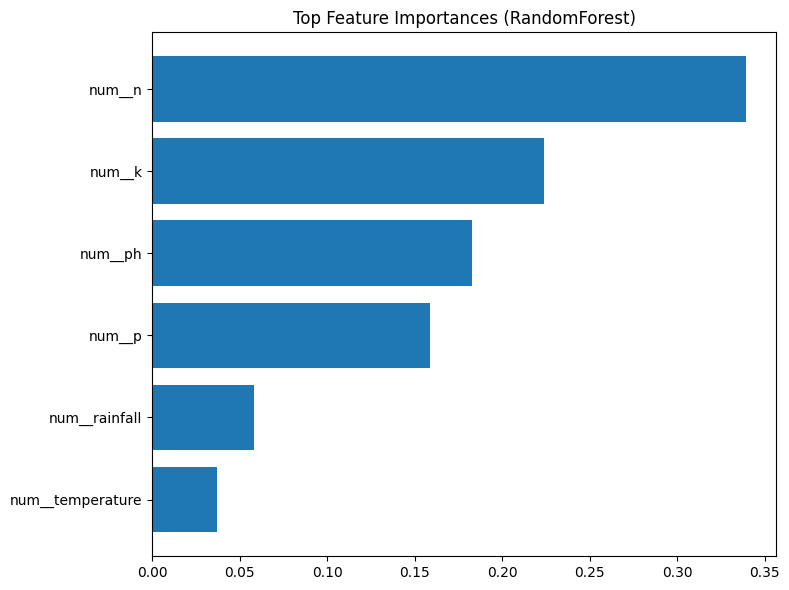

In [20]:
def get_ct_feature_names_fitted(ct, input_features):
    """
    Return output feature names from a *fitted* ColumnTransformer.
    Uses ct.get_feature_names_out when available, otherwise unwraps fitted inner estimators.
    """
    if not hasattr(ct, "transformers_"):
        raise NotFittedError("ColumnTransformer is not fitted yet. Fit your pipeline before calling this.")

    # 1) Best path (sklearn >= 1.0+)
    try:
        return ct.get_feature_names_out(input_features)
    except Exception:
        pass  # fall back to manual path below

    # 2) Manual path (robust across versions)
    output_features = []
    for name, trans, cols in ct.transformers_:
        # skip explicitly dropped groups
        if name == "remainder" and trans == "drop":
            continue

        # fetch the *fitted* transformer by name (important!)
        fitted_trans = ct.named_transformers_.get(name, trans)

        # passthrough: keep original column names
        if fitted_trans == "passthrough" or trans == "passthrough":
            output_features.extend(list(cols))
            continue

        # unwrap pipelines to their last step
        last = fitted_trans
        if hasattr(fitted_trans, "steps"):
            last = fitted_trans.steps[-1][1]

        # try to get names from the last step if it exposes them
        if hasattr(last, "get_feature_names_out"):
            try:
                fn = last.get_feature_names_out(cols)
            except NotFittedError:
                raise  # surface a clear error if somehow not fitted
            except TypeError:
                fn = np.asarray(cols, dtype=object)
        else:
            fn = np.asarray(cols, dtype=object)

        output_features.extend(fn.tolist())

    return np.asarray(output_features, dtype=object)

# ---- Fit, get names, and plot importances ----

print("columns =", X_train.columns)

# Make sure the *whole* pipeline is fitted
pipe.fit(X_train, y_train)

prep = pipe.named_steps["prep"]
model = pipe.named_steps["model"]

# robust feature-name extraction
feature_names = get_ct_feature_names_fitted(prep, X_train.columns)

# Guard: ensure lengths match (in case of odd transformers)
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_

    # If there is any mismatch, align to transformed shape
    if len(feature_names) != len(importances):
        Xt = prep.transform(X_train)
        feature_names = np.array(feature_names)[:Xt.shape[1]]
        importances = importances[:Xt.shape[1]]

    imp = pd.DataFrame({"feature": feature_names, "importance": importances})
    imp = imp.sort_values("importance", ascending=False).reset_index(drop=True)
    display(imp.head(20))

    top_k = 20
    plt.figure(figsize=(8, 6))
    plt.barh(imp["feature"].head(top_k)[::-1], imp["importance"].head(top_k)[::-1])
    plt.title("Top Feature Importances (RandomForest)")
    plt.tight_layout()
    plt.show()
else:
    print("Model does not expose feature_importances_.")



### Permutation importance (validation set)

,feature,importance_mean,importance_std
0,n,0.402434,0.004950
1,k,0.321460,0.007321
2,ph,0.173378,0.004770
3,p,0.152729,0.004187
4,rainfall,0.010177,0.002054
5,temperature,0.004499,0.001388
6,ph_bin,0.000000,0.000000
7,rainfall_bin,0.000000,0.000000
8,temp_bin,0.000000,0.000000


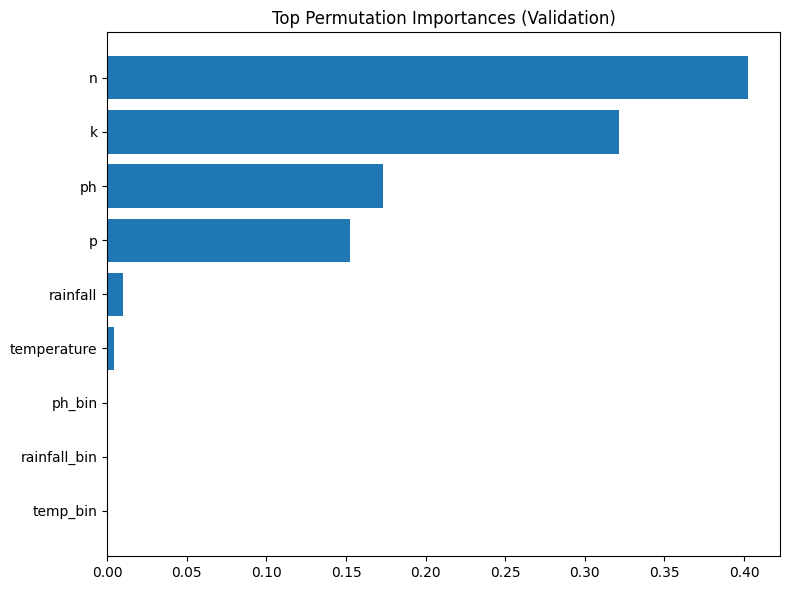

In [22]:
from sklearn.inspection import permutation_importance

# Run on the pipeline so permutation happens on raw columns
r = permutation_importance(pipe, X_val, y_val,
                           n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1)

perm_imp = (pd.DataFrame({
    'feature': X_val.columns,
    'importance_mean': r.importances_mean,
    'importance_std':  r.importances_std
})
.sort_values('importance_mean', ascending=False)
.reset_index(drop=True))

display(perm_imp.head(20))

plt.figure(figsize=(8,6))
plt.barh(perm_imp['feature'].head(20)[::-1], perm_imp['importance_mean'].head(20)[::-1])
plt.title('Top Permutation Importances (Validation)')
plt.tight_layout()
plt.show()



## Handling Missing Values for Training


Missing value handling is baked into the preprocessing pipeline via `SimpleImputer`:
- Numeric: median
- Categorical: most frequent

You can change strategies (e.g., `mean`, `constant`) in the pipeline if needed.


## Classify Time Data into Categories or Bins


If your data includes a date/time column, we derive `*_month` and `*_season`.  
This Kaggle dataset does **not** include time, so the step is **no‑op** unless you add such a column.


## Final Model & Test Evaluation

In [23]:

# Refit on train+val, then evaluate on held-out test
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([y_train, y_val])

pipe.fit(X_trval, y_trval)
y_test_pred = pipe.predict(X_test)

print('Test classification report:')
print(classification_report(y_test, y_test_pred, zero_division=0))

# Save artifacts if needed
out_dir = Path('artifacts')
out_dir.mkdir(exist_ok=True)
# Save processed splits for future modeling
pd.concat([X_train, pd.Series(y_train, name=target_col, index=X_train.index)], axis=1).to_csv(out_dir/'train.csv', index=False)
pd.concat([X_val,   pd.Series(y_val,   name=target_col, index=X_val.index)],   axis=1).to_csv(out_dir/'val.csv', index=False)
pd.concat([X_test,  pd.Series(y_test,  name=target_col, index=X_test.index)],  axis=1).to_csv(out_dir/'test.csv', index=False)

print('Saved splits to', out_dir.resolve())


Test classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        98
           2       1.00      1.00      1.00        71
           3       1.00      1.00      1.00        92
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00        62
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00        82
           9       1.00      1.00      1.00         3
          10       0.56      0.53      0.54       158
          11       0.42      0.45      0.44        31
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00       297
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00       199

## Optional: Outlier filtering recipe (IQR capping / IsolationForest)

In [28]:

def iqr_cap(frame: pd.DataFrame, cols: List[str], k: float = 1.5) -> pd.DataFrame:
    g = frame.copy()
    for c in cols:
        s = g[c].astype(float)
        q1, q3 = np.percentile(s.dropna(), [25, 75])
        iqr = q3 - q1
        low, high = q1 - k*iqr, q3 + k*iqr
        g[c] = s.clip(lower=low, upper=high)
    return g

# Example usage (commented out by default):
df_capped = iqr_cap(df, expected_numeric, k=1.5)

# IsolationForest-based removal (use cautiously for small datasets):
iso = IsolationForest(random_state=RANDOM_STATE, contamination=0.03)
mask = iso.fit_predict(df[expected_numeric]) == 1
df_iso = df[mask].reset_index(drop=True)
print('IsolationForest kept rows:', df_iso.shape)


IsolationForest kept rows: (17536, 7)


## Appendix

In [29]:

print('DataFrame head (post FE):')
df_fe.head()


DataFrame head (post FE):


,crop,n,p,k,ph,rainfall,temperature,ph_bin,rainfall_bin,temp_bin
0,1,70,40,45,5.54,75.32,22.676000,acidic,low,cool
1,35,50,60,30,5.54,297.66,29.566667,acidic,medium,hot
2,36,90,20,120,5.02,689.88,29.037273,acidic,medium,hot
3,33,80,40,40,5.66,297.66,29.566667,acidic,medium,hot
4,34,20,60,20,5.38,1011.49,30.430000,acidic,high,hot
